In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import logging
import os.path
import sys
import gensim
import pandas as pd

# silience .loc warning
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import sklearn.model_selection
import random
# for charts
import matplotlib.pyplot as plt
# natural language toolkit
import nltk
# To create Corpus
import gensim.corpora as corpora
from pprint import pprint

# for Topic model
from gensim.corpora import Dictionary, HashDictionary, MmCorpus, WikiCorpus
from gensim.models import TfidfModel
# for cross validation
from sklearn.model_selection import train_test_split
# for NF model
from sklearn.linear_model import LogisticRegression
# for confusion matrix
from sklearn import metrics
# for standard stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# to count repeated words across topics 
from collections import Counter

In [3]:
def create_docs(df,col):
    # Create LDA from DM
    # Split documents
    docs_list = df[col].to_list()
    texts = [d.split() for d in docs_list]
    # Create Dictionary
    id2word = corpora.Dictionary(texts)
    # Term Document Frequency (corpus)
    corpus = [id2word.doc2bow(text) for text in texts]
    return id2word, corpus

In [4]:
def create_topics(df,col):
    list_art = df[col].to_list()
    dataset = [d.split() for d in list_art]
    art_corpus = [id2word.doc2bow(text) for text in dataset]
#     return(art_corpus)

    vecs = []
    for i in range(len(art_corpus)):
        top_topics = (
            lda.get_document_topics(art_corpus[i],
                                          minimum_probability=0.0)
        )
        topic_vec = [top_topics[i][1] for i in range(len(top_topics))]
#         topic_vec.append(label)
        vecs.append(topic_vec)
    df = pd.DataFrame(np.row_stack(vecs))

    return df

In [5]:
def nfp(final_topics):
    X = final_topics.loc[:,final_topics.columns != 'label']
    y = final_topics['label'] # Target variable
    # split X and y into training and testing sets
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
    # instantiate the model (using the default parameters)
    logreg = LogisticRegression()
    # fit the model with data
    logreg.fit(X_train,y_train)
    # predict y
    y_pred=logreg.predict(X_test)
    y_pred_train=logreg.predict(X_train)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    cnf_matrix_train = metrics.confusion_matrix(y_train, y_pred_train)
    return cnf_matrix, cnf_matrix_train

In [6]:
def get_results(cnf_mtx):
    TN = cnf_mtx[0,0]
    TP = cnf_mtx[1,1]
    FP = cnf_mtx[0,1]
    FN = cnf_mtx[1,0]
    accuracy = (TP + TN) / (TP+TN+FP+FN)
    precision = TP / (TP + FN)
    recall = TP / (TP + FP) 
    return accuracy, precision, recall ,TN, FN, FP, TP

In [7]:
def split_articles(df,col,new_col1,new_col2):
    split_list = []
    art_list = df[col].to_list()
#     art_list = dm['articles'].to_list()
    for a in range(len(df)):
        i = art_list[a]
        half = len(i)//2
        part_1 = i[0:half-1]
        part_2 = i[half:len(i)]
        split_list.append([part_1, part_2])
    df1 = pd.DataFrame(split_list, columns=[new_col1,new_col2])
    return df1

In [8]:
def rand_pt2(df,col):
    df_split = split_articles(df,col,'part1','part2')
    bad_df=pd.DataFrame()
    bad_df['part2'] = np.random.permutation(df_split['part2'].values)
    bad_df['all'] = df_split.part1.str.cat(bad_df.part2)
    return bad_df

In [9]:
def test_topics(good_df,col1,bad_df, col2):
    good_topics = create_topics(good_df,col1)
    good_topics['label'] = 1
    bad_topics = create_topics(bad_df,col2)
    bad_topics['label'] = 0
    final_topics = good_topics.append(bad_topics)
    return nfp(final_topics)

In [10]:
def main(corpus,id2word,num_topics,df,col):
    lda = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
    split = split_articles(df,col,'part1','part2')
    bad_df = rand_pt2(split,'part2')
    cnf_matrix, cnf_matrix_train = test_topics(df,col,bad_df,'all')
    return lda, num_topics, get_results(cnf_matrix), get_results(cnf_matrix_train)

In [11]:
def create_remove_list(t):    
    # select topics and their words, includes %
    x=lda.show_topics(num_topics=t, num_words=10,formatted=False)
    # select only words and save
    topics_words = [[wd[0] for wd in tp[1]] for tp in x]
    # count number of times word appears
    my_counter = Counter()
    for word in topics_words:
        my_counter.update(word)
    # save words where they ap pear 5 or more times
    to_remove = Counter({k: c for k, c in my_counter.items() if c >= 5})
    # as list
    to_remove_list = list(to_remove)
    stop_words.extend(to_remove_list)
    return to_remove_list

In [12]:
def remove_stops(df,col_old):
    df['col_new'] = df[col_old]

    for stop_word in stop_words:

        regex_stopword = r"\b" + stop_word + r"\b"
        df['col_new'] =df['col_new'].str.replace(regex_stopword, '')
    return df['col_new']

In [13]:
def clean(df,col):
    # turn into cleaning function
    df['Clean_1'] = df[col].str.lower()
    df['Clean_1'] = df['Clean_1'].str.replace("\r", " ")
    df['Clean_1'] = df['Clean_1'].str.replace("\n", " ")
    df['Clean_1'] = df['Clean_1'].str.replace("    ", " ")
    df['Clean_1'] = df['Clean_1'].str.replace('"', '')
    df['Clean_1'] = df['Clean_1'].str.replace("\\'", "") 
    df['Clean_1'] = df['Clean_1'].str.replace("–", " ") 
    # posessive nouns
    df['Clean_1'] = df['Clean_1'].str.replace("'s", "")
    df['Clean_1'] = df['Clean_1'].str.replace('’', "")

    punctuation_signs = list("?:!.,;/-–")
#     df['Clean_2'] = df['Clean_1']
    for punct_sign in punctuation_signs:
        df['Clean_1'] = df['Clean_1'].str.replace(punct_sign, '')
    return df['Clean_1'] 

In [14]:
def lemm(df,col):
    # TURN INTO FUNCTION
    # lemmatize
    wordnet_lemmatizer = WordNetLemmatizer()
    nrows = len(dm)
    lemmatized_text_list = []
    for row in range(0, nrows):
            # Create an empty list containing lemmatized words
            lemmatized_list = []
            # Save the text and its words into an object
            text = df.loc[row][col]
            text_words = text.split(" ")
            # Iterate through every word to lemmatize
            for word in text_words:
                lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
            # Join the list
            lemmatized_text = " ".join(lemmatized_list)
            # Append to the list containing the texts
            lemmatized_text_list.append(lemmatized_text)

    return lemmatized_text_list

# Set up

In [15]:
random.seed(1)

In [16]:
folder = '/Users/sarahbloomfield/Desktop/MSc Comp Sci/Project/Wiki/'


In [17]:
# wiki LDA
wiki_lda = gensim.models.ldamodel.LdaModel.load(folder+'lda.model')
wiki_id2word = gensim.corpora.Dictionary.load_from_text(folder+'test_long_wordids.txt.bz2')

In [18]:
dm = pd.read_csv('dm_20211205_10294.csv')

In [19]:
id2word, corpus = create_docs(dm,'articles')

In [20]:
# Clean unwanted text
dm['Clean_2'] = clean(dm,'articles')

In [21]:
# Lemmatize 
dm['Clean_3'] = lemm(dm,'Clean_2')

In [22]:
# Remove stopwords
stop_words = list(stopwords.words('english'))
dm['Clean_4'] = remove_stops(dm,'Clean_3')


In [23]:
# # Remove extendedstopwords
# stop_words_extended = pd.read_csv('stop_words.csv')
# stop_words = list(stop_words_extended['0'])
# dm['Clean_4'] = remove_stops(dm,'Clean_3')


In [24]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [25]:
# stop_words_extended = pd.read_csv('stop_words.csv')
# stop_words_extended['0']

# Initial model

In [26]:
id2word, corpus = create_docs(dm,'Clean_4')

In [27]:
# Need to define lda before running main process
lda = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10)

In [28]:
lda, num_topics, results, results_train = main(corpus,id2word,10,dm,'Clean_4')


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

In [29]:
print(results)
print(results_train)

(0.5183602098309695, 0.5056136275648471, 0.5207336523125997, 1362, 1277, 1202, 1306)
(0.534874684282106, 0.5144598625340423, 0.5357191087103309, 4292, 3744, 3438, 3967)


In [30]:
# lda, num_topics, results, results_train = main_process(corpus,id2word,10)
# print(results)
# print(results_train)

In [31]:
#Repeat 100 for distribution
results_all = []
results_train_all = []
for i in range (0,100):
    print(i)
    lda, num_topics, results, results_train = main(corpus,id2word,10,dm,'Clean_4')
    results_list = list(results)
    results_train_list = list(results_train)
    results_train_all.append(results_train_list)
    results_all.append(results_list)

0
1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

6


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

7


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

8


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

9


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

In [32]:
results_initial_df = pd.DataFrame (results_all)
# results_initial_df

In [33]:
results_in_tn_df = pd.DataFrame (results_train_all)
# results_in_tn_df

In [34]:
print('min:', min(results_initial_df[0]))
print('max:', max(results_initial_df[0]))
print('mean:', sum(results_initial_df[0])/(len(results_initial_df[0])))
print('std dev:', np.std(results_initial_df[0]))


min: 0.5175830580920925
max: 0.5449776568875073
mean: 0.5291820477948319
std dev: 0.007436457946429464


In [35]:
print('min:', min(results_in_tn_df[0]))
print('max:', max(results_in_tn_df[0]))
print('mean:', sum(results_in_tn_df[0])/(len(results_in_tn_df[0])))
print('std dev:' ,np.std(results_in_tn_df[0]))


min: 0.5217926300110096
max: 0.5482157891328282
mean: 0.5308723528268895
std dev: 0.008906255373995574


(0.0, 10.0)

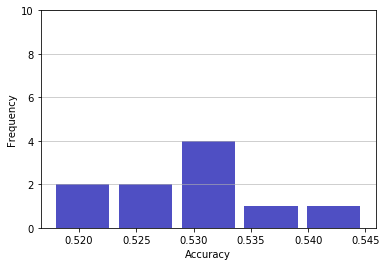

In [36]:
#  An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=results_initial_df[0], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 10.0)

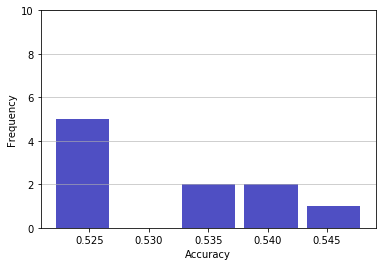

In [37]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=results_in_tn_df[0], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

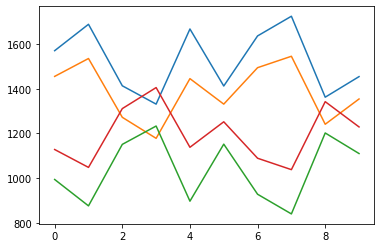

In [38]:
x= range(0,len(results_initial_df[0]))

y1 = results_initial_df[3]
y2 = results_initial_df[4]
y3 = results_initial_df[5]
y4 = results_initial_df[6]
plt.plot(x, y1, label = "line 1")
plt.plot(x, y2, label = "line 2")
plt.plot(x, y3, label = "line 3")
plt.plot(x, y4, label = "line 4")
plt.show()


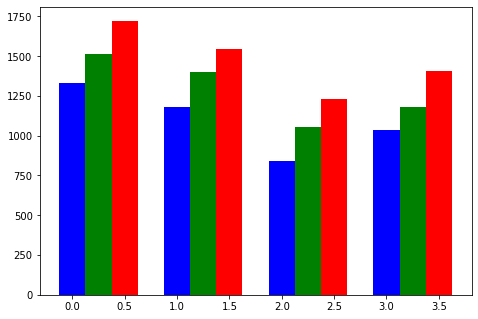

In [39]:

data = [[(np.percentile(results_initial_df[3], 0)),
        (np.percentile(results_initial_df[4], 0)), 
         (np.percentile(results_initial_df[5], 0)), 
         (np.percentile(results_initial_df[6], 0))],
[(np.percentile(results_initial_df[3], 50)),
        (np.percentile(results_initial_df[4], 50)), 
         (np.percentile(results_initial_df[5], 50)), 
         (np.percentile(results_initial_df[6], 50))],
[(np.percentile(results_initial_df[3], 100)),
        (np.percentile(results_initial_df[4], 100)), 
         (np.percentile(results_initial_df[5], 100)), 
         (np.percentile(results_initial_df[6], 100))]]
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)
plt.show()

In [40]:
# Show topics from final lda model
lda.show_topics(num_topics=10, num_words=10,formatted=False)

[(0,
  [('say', 0.010199688),
   ('get', 0.005883678),
   ('go', 0.004779463),
   ('one', 0.004042647),
   ('make', 0.0040187165),
   ('take', 0.003726608),
   ('also', 0.0036612991),
   ('last', 0.00337272),
   ('new', 0.0032771952),
   ('two', 0.003001845)]),
 (1,
  [('say', 0.016074955),
   ('also', 0.004561705),
   ('get', 0.0045382255),
   ('people', 0.004385519),
   ('go', 0.0043315934),
   ('one', 0.0039246664),
   ('take', 0.0038766793),
   ('make', 0.0038427091),
   ('would', 0.0032714985),
   ('first', 0.0030182945)]),
 (2,
  [('say', 0.014843314),
   ('time', 0.005584171),
   ('go', 0.0049991775),
   ('take', 0.0043432987),
   ('make', 0.004298904),
   ('get', 0.003972622),
   ('would', 0.003958593),
   ('tell', 0.0038257835),
   ('people', 0.0037997887),
   ('also', 0.003564696)]),
 (3,
  [('say', 0.007909612),
   ('people', 0.0050085406),
   ('get', 0.0047843475),
   ('time', 0.0044287066),
   ('one', 0.004181242),
   ('make', 0.0041233455),
   ('go', 0.0038922979),
   ('a

In [41]:
# from gensim.models import CoherenceModel
# coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=id2word, coherence='c_v')
# coherence_model_lda.get_coherence()

# Testing removing stopwords

In [ ]:
stop_words_added = []
stop_words_to_remove = []
results_stopw = []
results_sw_train = []

In [ ]:
for x in range(0,2):
    print(x)
    id2word, corpus = create_docs(dm,'Clean_4')
    lda, num_topics, results, results_train = main(corpus,id2word,10,dm,'Clean_4')
    to_remove_list = (create_remove_list(10))
    print(to_remove_list)
    stop_words.extend(to_remove_list)
    dm['Clean_4'] = remove_stops(dm,'Clean_4')
    stop_words_to_remove.append(to_remove_list)
    num_stopw = len(to_remove_list)
    print(num_stopw)
    stop_words_added.append(num_stopw)
    print(results)
    results_list = list(results)
    results_sw_train_list = list(results_train)
    results_stopw.append(results_list)
    results_sw_train.append(results_sw_train_list)

    if num_stopw == 0:
        break


In [ ]:
print(stop_words_added)
print(stop_words_to_remove)
print(results_stopw)

In [ ]:
results_sw_df = pd.DataFrame (results_stopw)
results_sw_df['num_sw'] = stop_words_added
# df = pd.DataFrame (products_list, columns = ['product_name'])
results_sw_df

In [ ]:
stopwords_removed_df = pd.DataFrame (stop_words_to_remove)
stopwords_removed_df

In [ ]:
x= range(0,len(results_sw_df['num_sw']))
y = results_sw_df[0]

plt.plot(x, y)
plt.show()

In [ ]:
x= range(0,len(results_sw_df['num_sw']))
y1 = results_sw_df[0]

y1 = results_sw_df[3]
y2 = results_sw_df[4]
y3 = results_sw_df[5]
y4 = results_sw_df[6]
plt.plot(x, y1, label = "line 1")
plt.plot(x, y2, label = "line 2")
plt.plot(x, y3, label = "line 3")
plt.plot(x, y4, label = "line 4")
plt.show()

plt.plot(x, y)
plt.show()

In [ ]:
lda.show_topics(num_topics=10, num_words=10,formatted=False)


In [ ]:
# stop_words_df = pd.DataFrame (stop_words)
# stop_words_df.to_csv('stop_words.csv')  

In [42]:
# Remove extendedstopwords
stop_words_extended = pd.read_csv('stop_words.csv')
stop_words = list(stop_words_extended['0'])
dm['Clean_4'] = remove_stops(dm,'Clean_3')


# Testing number of topics

In [44]:
topics_tested = []
results_all = []
results_train_all = []
for t in range(5, 205, 50): 
    print(t)
    lda, num_topics, results, results_train = main(corpus,id2word,t,dm,'Clean_4')
    topics_tested.append(num_topics)
    results_list = list(results)
    results_train_list = list(results_train)
    results_train_all.append(results_train_list)
    results_all.append(results_list)

5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

55


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

105


KeyboardInterrupt: 

In [45]:
results_df = pd.DataFrame (results_all)
results_df['topics'] = topics_tested
# df = pd.DataFrame (products_list, columns = ['product_name'])
results_df

,0,1,2,3,4,5,6,topics
0,0.534486,0.434766,0.545410,1628,1460,936,1123,5
1,0.512920,0.485482,0.515625,1386,1329,1178,1254,55


In [46]:
max(results_df[0])

0.5344861084126675

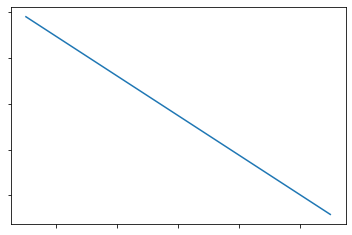

In [47]:
x= results_df['topics']
y = results_df[0]

plt.plot(x, y)
plt.show()

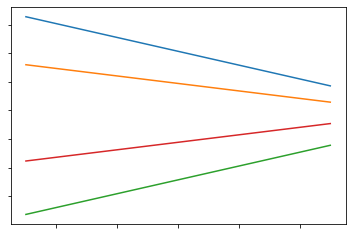

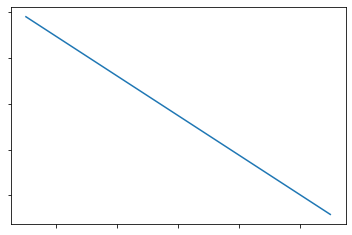

In [48]:
x= results_df['topics']

y1 = results_df[3]
y2 = results_df[4]
y3 = results_df[5]
y4 = results_df[6]
plt.plot(x, y1, label = "line 1")
plt.plot(x, y2, label = "line 2")
plt.plot(x, y3, label = "line 3")
plt.plot(x, y4, label = "line 4")
plt.show()

plt.plot(x, y)
plt.show()

In [49]:
lda.show_topics(num_topics=205, num_words=10,formatted=False)

[(0,
  [('say', 0.006732519),
   ('july', 0.005905216),
   ('make', 0.0051462403),
   ('also', 0.0047808415),
   ('people', 0.004249259),
   ('one', 0.0036869734),
   ('police', 0.0033081088),
   ('time', 0.003282165),
   ('tell', 0.0032074342),
   ('two', 0.0030155259)]),
 (1,
  [('say', 0.015628647),
   ('time', 0.0050325324),
   ('get', 0.0047581424),
   ('make', 0.004528172),
   ('take', 0.004367609),
   ('people', 0.004354573),
   ('also', 0.00409403),
   ('would', 0.0039044505),
   ('go', 0.0033814604),
   ('one', 0.003207287)]),
 (2,
  [('say', 0.010694629),
   ('get', 0.0043834983),
   ('also', 0.0043564704),
   ('people', 0.004303867),
   ('time', 0.0038635714),
   ('make', 0.003322371),
   ('one', 0.0032941718),
   ('take', 0.0032801183),
   ('go', 0.0032775162),
   ('two', 0.0032384056)]),
 (3,
  [('say', 0.007917632),
   ('make', 0.006356533),
   ('also', 0.0045720506),
   ('time', 0.0042325),
   ('one', 0.0040808027),
   ('last', 0.0038816372),
   ('go', 0.0037397353),
   

# Testing changing LDA source to wikipedia

In [50]:
# wiki LDA
lda = gensim.models.ldamodel.LdaModel.load(folder+'lda.model')
id2word = gensim.corpora.Dictionary.load_from_text(folder+'test_long_wordids.txt.bz2')

In [51]:
# pprint(lda.print_topics())

In [52]:
# print top 10 words from 100 topics
lda.show_topics(num_topics=100, num_words=10,formatted=False)


[(0,
  [('lecturer', 0.06349735),
   ('martyrs', 0.052489426),
   ('brook', 0.050411966),
   ('clara', 0.046841208),
   ('geneva', 0.04489581),
   ('icon', 0.043289665),
   ('fellowship', 0.039718796),
   ('fuller', 0.035809264),
   ('zion', 0.030951215),
   ('feast', 0.027555913)]),
 (1,
  [('scotland', 0.06440498),
   ('scottish', 0.059256803),
   ('edinburgh', 0.04020527),
   ('glasgow', 0.031218031),
   ('perth', 0.023348784),
   ('dundee', 0.017314676),
   ('baronet', 0.015889438),
   ('hamilton', 0.0109048765),
   ('burns', 0.010224116),
   ('kinross', 0.010146347)]),
 (2,
  [('castle', 0.0103837615),
   ('king', 0.008523365),
   ('clan', 0.0076974444),
   ('prince', 0.006942132),
   ('son', 0.0063953544),
   ('emperor', 0.0055082645),
   ('princess', 0.004938319),
   ('monastery', 0.003975638),
   ('battle', 0.0036181249),
   ('reign', 0.0036168017)]),
 (3,
  [('language', 0.038402423),
   ('teachers', 0.030354826),
   ('schools', 0.0291956),
   ('elementary', 0.025324404),
   (

In [53]:
# results_train_wiki = []
# results_wiki = []
# for i in range (0,20):
#     print(i)
#     lda, num_topics, results, results_train = main_process(corpus,id2word,10)
#     results_list = list(results)
#     results_train_list = list(results_train)
#     results_train_wiki.append(results_train_list)
#     results_wiki.append(results_list)

In [54]:
results_train_wiki = []
results_wiki = []
for i in range (0,20):
    print(i)
#     lda, num_topics, results, results_train = main(corpus,id2word,t)
    split = split_articles(dm,'Clean_4','part1','part2')
    bad_df = rand_pt2(split,'part2')
    cnf_matrix, cnf_matrix_train = test_topics(df,col,bad_df,'all')

    results = get_results(cnf_matrix)
    results_train = get_results(cnf_matrix_train)
    
    results_list = list(results)
    results_train_list = list(results_train)
    results_train_wiki.append(results_train_list)
    results_wiki.append(results_list)

0


NameError: name 'df' is not defined

In [ ]:
results_wiki_df = pd.DataFrame (results_wiki)
results_wiki_df

In [ ]:
results_train_wiki_df = pd.DataFrame (results_train_wiki)
results_train_wiki_df 

In [ ]:
x= range(0,len(results_wiki_df[0]))
y = results_wiki_df[0]

plt.plot(x, y)
plt.show()

In [ ]:
print('Min: ',min(results_wiki_df[0]))
print('Max: ',max(results_wiki_df[0]))
print('Mean: ',sum(results_wiki_df[0])/(len(results_wiki_df[0])))
print('Std dev: ',np.std(results_wiki_df[0]))

In [ ]:
lda.show_topics(num_topics=100, num_words=10,formatted=False)

In [ ]:
#  An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=results_wiki_df[0], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
#  An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=results_train_wiki_df[0], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
print('Min: ',min(results_train_wiki_df[0]))
print('Max: ',max(results_train_wiki_df[0]))
print('Mean: ',sum(results_train_wiki_df[0])/(len(results_wiki_df[0])))
print('Std dev: ',np.std(results_train_wiki_df[0]))

In [ ]:
# results_wiki_df[3] 1546
# results_wiki_df[4] 1018
# results_wiki_df[5] 1333
# # results_wiki_df[6] §§§§§§1
# results_wiki 0.543229065475034,
#   0.5511463844797179,
#   0.48393341076267904,
training_df  = pd.DataFrame()
training_df['y_test'] = y_test

training_df['y_pred'] = y_pred
training_df
# y_pred
# y_test
# # y

In [ ]:
dm['articles']

In [ ]:
pd.set_option("display.max_rows", None)
good_topics.iloc[[6295]].T

In [ ]:
# pd.set_option("display.max_rows", None)
bad_topics.iloc[[9586]].T 

In [ ]:
good_topics.iloc[[10291]].T

In [ ]:
pd.set_option('display.max_colwidth', None)
bad_df.iloc[[9586]]

In [ ]:
x= range(0,len(results_wiki_df[0]))

y1 = results_wiki_df[3]
y2 = results_wiki_df[4]
y3 = results_wiki_df[5]
y4 = results_wiki_df[6]
plt.plot(x, y1, label = "line 1")
plt.plot(x, y2, label = "line 2")
plt.plot(x, y3, label = "line 3")
plt.plot(x, y4, label = "line 4")
plt.show()

In [ ]:

data = [[(np.percentile(results_wiki_df[3], 0)),
        (np.percentile(results_wiki_df[4], 0)), 
         (np.percentile(results_wiki_df[5], 0)), 
         (np.percentile(results_wiki_df[6], 0))],
[(np.percentile(results_wiki_df[3], 50)),
        (np.percentile(results_wiki_df[4], 50)), 
         (np.percentile(results_wiki_df[5], 50)), 
         (np.percentile(results_wiki_df[6], 50))],
[(np.percentile(results_wiki_df[3], 100)),
        (np.percentile(results_wiki_df[4], 100)), 
         (np.percentile(results_wiki_df[5], 100)), 
         (np.percentile(results_wiki_df[6], 100))]]
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)
plt.show()

In [ ]:
final_topics

In [ ]:
# final_topics.mean(axis=0,index ='label')
mean_label = final_topics.groupby('label').mean()
mean_label

In [ ]:
mean_label.to_csv('mean_label.csv')  

In [ ]:
mean_label_T = mean_label.T
mean_label_T

In [ ]:
x= range(0,len(mean_label_T[0]))

y1 = mean_label_T[0]
y2 = mean_label_T[1]
plt.plot(x, y1, label = "line 1")
plt.plot(x, y2, label = "line 2")
plt.show()

In [ ]:
# from sklearn.cluster import KMeans
  
# kmeans = KMeans(n_clusters=3).fit(bad_topics)
# centroids = kmeans.cluster_centers_
# print(centroids)

# plt.scatter(bad_topics[10], bad_topics[13], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
# plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
# plt.show()

In [ ]:
# np.percentile(mean_label_T[0], 0)

In [ ]:
# final_topics
# final_topics.loc[final_topics['label'] == 1]
# bad_sample = bad_topics.sample(n=100, random_state=1)

In [ ]:
# bad_topics
bins = [0, .20, .40, .60, .80, 1.00]
bad_topics['bin10'] = pd.cut(bad_topics[10], bins)
bad_topics['bin13'] = pd.cut(bad_topics[13], bins)
bad_topics['bin84'] = pd.cut(bad_topics[84], bins)
bad_topics['bin9'] = pd.cut(bad_topics[9], bins)
bad_topics['bin23'] = pd.cut(bad_topics[23], bins)
bad_topics['bin58'] = pd.cut(bad_topics[58], bins)
good_topics['bin10'] = pd.cut(good_topics[10], bins)
good_topics['bin13'] = pd.cut(good_topics[13], bins)
good_topics['bin84'] = pd.cut(good_topics[84], bins)
good_topics['bin9'] = pd.cut(good_topics[9], bins)
good_topics['bin23'] = pd.cut(good_topics[23], bins)
good_topics['bin58'] = pd.cut(good_topics[58], bins)

In [ ]:
good_bin_df = pd.DataFrame()
good_bin_df['g_bin10'] = good_topics['bin10'].value_counts()
good_bin_df['g_bin13'] = good_topics['bin13'].value_counts()
good_bin_df['g_bin84'] = good_topics['bin84'].value_counts()
good_bin_df['g_bin9'] = good_topics['bin9'].value_counts()
good_bin_df['g_bin23'] = good_topics['bin23'].value_counts()
good_bin_df['g_bin58'] = good_topics['bin58'].value_counts()
good_bin_df

In [ ]:
bad_bin_df = pd.DataFrame()
bad_bin_df['bin10'] = bad_topics['bin10'].value_counts()
bad_bin_df['bin13'] = bad_topics['bin13'].value_counts()
bad_bin_df['bin84'] = bad_topics['bin84'].value_counts()
bad_bin_df['bin9'] = bad_topics['bin9'].value_counts()
bad_bin_df['bin23'] = bad_topics['bin23'].value_counts()
bad_bin_df['bin58'] = bad_topics['bin58'].value_counts()
bad_bin_df

In [ ]:
bad_topics['bin10'].value_counts()

In [ ]:
bad_topics['bin13'].value_counts()

In [ ]:
bad_topics['bin84'].value_counts()

In [ ]:
print(good_topics['bin10'].value_counts())
print(good_topics['bin13'].value_counts())
print(good_topics['bin84'].value_counts())
# print(good_topics['bin9'].value_counts())
# print(good_topics['bin23'].value_counts())
# print(good_topics['bin58'].value_counts())

In [ ]:
bin_df = pd.DataFrame()
bin_df['g_bin10'] = good_topics['bin10'].value_counts()
bin_df['g_bin13'] = good_topics['bin13'].value_counts()
bin_df['g_bin84'] = good_topics['bin84'].value_counts()
bin_df

In [ ]:
good_sample = good_topics.sample(n=100, random_state=1)
good_sample = good_sample[[10, 13,84,9,23,58]]
sns.heatmap(good_sample, annot=False)

In [ ]:
bad_sample = bad_sample[[10, 13,84,9,23,58]]

In [ ]:
sns.heatmap(bad_sample, annot=False)

In [ ]:
# mport numpy as np 
# from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
Cols = ['A', 'B', 'C', 'D']
df = pd.DataFrame(abs(np.random.randn(5, 4)), index=Index, columns=Cols)

sns.heatmap(df, annot=True)

In [ ]:
data = [[(np.percentile(mean_label_T[0], 0)),
        (np.percentile(mean_label_T[1], 0))],
[(np.percentile(mean_label_T[0], 50)),
        (np.percentile(mean_label_T[1], 50))],
[(np.percentile(mean_label_T[0], 100)),
        (np.percentile(mean_label_T[1], 100))]]
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)
plt.show()

# Test different article lengths

In [ ]:
dm['art_len']  = dm['articles'].str.len()

In [ ]:
print(np.percentile(dm['art_len'], 0))
print(np.percentile(dm['art_len'], 25))
print(np.percentile(dm['art_len'], 50))
print(np.percentile(dm['art_len'], 75))
print(np.percentile(dm['art_len'], 100))


In [ ]:
73144/2

In [ ]:
# import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=dm['art_len'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Article Length')
plt.ylabel('Frequency')
plt.title('')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
def fil_len (df, mini, maxi):
    df.loc[df['art_len'] <= maxi, 'not_long'] = 1  
    df.loc[df['art_len'] > maxi, 'not_long'] = 0  
    df.loc[df['art_len'] < mini, 'not_short'] = 0  
    df.loc[df['art_len'] >= mini, 'not_short'] = 1  
    df.loc[df['not_long'] + dm['not_short'] ==2 , 'good_len'] = 1
    df.loc[df['not_long'] + dm['not_short'] !=2 , 'good_len'] = 0
    df = df.loc[df['good_len'] ==1]
    return df


In [ ]:
dm_ln = dm
dm_ln = fil_len(dm, 1500,30000)
print(len(dm_ln))

In [ ]:
min_ln = [2100, 2000, 1900, 1800, 1700, 1600, 1500,   1400,  1300,  1200,  1100  ,1000,  900,   800,   700   ,600   ,500   ,400   ,300   ,200    ,100  ,0]
max_ln = [5000, 6000, 7000, 8000, 9000, 10000, 15000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 80000, 80000, 80000, 80000, 80000, 80000, 80000, 80000]
test_len = pd.DataFrame()
test_len['min_ln'] = min_ln
test_len['max_ln'] = max_ln

In [ ]:
test_len

In [ ]:
num_art = []

for i in range(len(test_len)):
    min_i = test_len.loc[i,'min_ln'] 
    max_i = test_len.loc[i,'max_ln'] 
    dm_ln = fil_len(dm,min_i,max_i)
    num_art_i = len(dm_ln)
    num_art.append(num_art_i)


In [ ]:
test_len['num_art']=num_art
test_len

In [ ]:
dm_ln = fil_len(dm, 5000,10000)
print(len(dm_ln))
dm_ln

In [ ]:
# stop_words_added = []
# stop_words_to_remove = []
results_ln = []
for i in range(len(test_len)):
    print (i)
    min_i = test_len.loc[i,'min_ln'] 
    max_i = test_len.loc[i,'max_ln'] 
    dm_ln = fil_len(dm, min_i,max_i)
    good_topics = create_topics(dm_ln,'articles')
    good_topics['label'] = 1
    print("good topics created")
    dm_split = split_articles(dm_ln,'articles')
    print("split articles")
    # Create bad articles by randomising second half
    bad_df =  pd.DataFrame()
    bad_df['part1'] = dm_split['part1']
    bad_df['part2'] = np.random.permutation(dm_split['part2'].values)
    # and merge
    bad_df['all'] = bad_df.part1.str.cat(bad_df.part2)
    bad_topics = create_topics(bad_df,'all')
    bad_topics['label'] = 0
    print("bad topics created")
    # Dataset with good and bad articles
    final_topics = good_topics.append(bad_topics)
    print("final topics merged")
    # Create NF Model
    X = final_topics.loc[:,final_topics.columns != 'label']
    y = final_topics['label'] # Target variable
    # split X and y into training and testing sets
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
    # instantiate the model (using the default parameters)
    logreg = LogisticRegression()
    print("NF model set up")
    # fit the model with data
    logreg.fit(X_train,y_train)
    print("NF model trained")
    # predict y
    y_pred=logreg.predict(X_test)
    y_train_pred=logreg.predict(X_train)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    results = get_results(cnf_matrix)
    results_ln.append(results)
    print("complete")
    print(min_i)

In [ ]:
# results_ln

In [ ]:
results_ln_df = pd.DataFrame (results_ln)
results_ln_df

In [ ]:
x= range(0,22)
y = results_ln_df[0]

plt.plot(x, y)
plt.show()

In [ ]:
test_len['num_art'] = num_art

In [ ]:
test_len['accuracy']= results_ln_df[0]

In [ ]:
test_len

In [ ]:
# test_len = test_len.join(results_ln_df) 
# test_len

In [ ]:
# x= test_len['num_art']
# y = test_len[0]

# plt.plot(x, y)
# plt.show()

In [ ]:
# good_len_list = dm_ln['articles'].to_list()

# 3.6.5 Test article length


To test the impact of sample size on modelling performance, a random sample of x documents were taken from the corpus, where x was 5,000 to 10,000 increasing in chunks of 500. In keeping with the overall methodology, those articles were then turned into poor articles by randomising the second half of the article, therefore the model is fed 10,000 to 20,000 examples. Testing whether the model seeing half of the poor article previously is a separate test.

In [ ]:
smp_sz = []
for i in range (1000,20010,10):
    smp_sz.append(i)

In [ ]:
# smp_sz

In [ ]:
# final_topics

In [ ]:
# random.sample(final_topics[0], 5)
# df = final_topics.sample(5)
results_ss = []
for i in smp_sz:
    print(i)
    sample_topics = final_topics.sample(i)
    X = sample_topics.loc[:,sample_topics.columns != 'label']
    y = sample_topics['label'] # Target variable
    # split X and y into training and testing sets
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
    # instantiate the model (using the default parameters)
    logreg = LogisticRegression()
    print("NF model set up")
    # fit the model with data
    logreg.fit(X_train,y_train)
    print("NF model trained")
    # predict y
    y_pred=logreg.predict(X_test)
    y_train_pred=logreg.predict(X_train)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    results = get_results(cnf_matrix)
    results_ss.append(results)
    print("complete")
#     print(df)

In [ ]:
results_ss_df = pd.DataFrame (results_ss)
results_ss_df

In [ ]:
x= smp_sz
y = results_ss_df[0]

plt.plot(x, y)
plt.show()

# 3.6.6 Break article into chunks of 2, 4, 6, 8, 10 and run topic model on each chunk



Instead of taking the full topic model, it is possible to break the article into smaller chunks and run the topic model on each section. The number of parameters, k, increases to s x t, where s is the number of sections and t the number of topics. 
To create the poor article, good articles are already split into two sections. Once poor articles are created the halfway point will be in a different place to the original split, as article lengths differ. However, to increase the chance of the model finding a narrative break, the split remains at the original position. The two sections (s = 2) are placed into the topic model separately for the topic distributions.
The two sections are then split further, so that s = 4, 6, 8, 10. The only randomisation is occurs when creating the poor articles.


In [ ]:
# dm['articles']
dm_ln = fil_len(dm, 1000,60000)
dm_ln['articles']

In [ ]:
dm_split = split_articles(dm_ln,'articles')
good_top_pt1 = create_topics(dm_split,'part1')
good_top_pt2 = create_topics(dm_split,'part2')
good_topics = pd.concat([good_top_pt1, good_top_pt2], axis=1)
# good_topics = create_topics(dm_ln,'articles')
good_topics['label'] = 1
print("good topics created")
bad_pt2 = good_top_pt2.sample(frac = 1).reset_index(drop=True)
bad_top_all = pd.concat([good_top_pt1, bad_pt2], axis=1)
bad_top_all['label'] = 0
print("bad topics created")
# Dataset with good and bad articles
final_topics = good_topics.append(bad_top_all)
print("final topics merged")
# Create NF Model
X = final_topics.loc[:,final_topics.columns != 'label']
y = final_topics['label'] # Target variable
# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
print("NF model set up")
# fit the model with data
logreg.fit(X_train,y_train)
print("NF model trained")
# predict y
y_pred=logreg.predict(X_test)
y_pred_train=logreg.predict(X_train)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix_train = metrics.confusion_matrix(y_train, y_pred_train)
results_spl2 = get_results(cnf_matrix)
results_train_spl2 = get_results(cnf_matrix_train)
# results_ss.append(results)
print("complete")

In [ ]:
results_spl2

In [ ]:
results_train_spl2

In [ ]:
def split_articles_4(df,col):
    cols = ['part1', 'part2', 'part3', 'part4']
    lst = []
    art_list = df[col].to_list()
    for a in range(len(df)):
        i = art_list[a]
        length = len(i)
        qtr = len(i)//6
        part_1 = i[0:qtr-1]
        part_2 = i[0+qtr:2*qtr-1]
        part_3 = i[0+2*qtr:3*qtr-1]
        part_4 = i[0+3*qtr:length]
        lst.append([part_1, part_2, part_3, part_4])
    df1 = pd.DataFrame(lst, columns=cols)
    return df1

dm_split = split_articles_4(dm,'articles')

top_pt1 = create_topics(dm_split,'part1')
top_pt2 = create_topics(dm_split,'part2')
top_pt3 = create_topics(dm_split,'part3')
top_pt4 = create_topics(dm_split,'part4')
print(type(top_pt4))
good_topics = pd.concat([top_pt1, top_pt2, top_pt3, top_pt4], axis=1)
# good_topics = create_topics(dm_ln,'articles')
good_topics['label'] = 1
print("good topics created")
# dm_split = split_articles(dm_ln,'articles')
# print("split articles")
# Create bad articles by randomising second half
# bad_df =  pd.DataFrame()
# bad_df['part1'] = dm_split['part1']
bad_pt3 = top_pt3.sample(frac = 1).reset_index(drop=True)
bad_pt4 = top_pt4.sample(frac = 1).reset_index(drop=True)

# bad_pt3 = np.random.permutation(top_pt3)
# bad_pt4 = np.random.permutation(top_pt4)
print(type(bad_pt3))
# and merge
# bad_df['all'] = bad_df.part1.str.cat(bad_df.part2)
# bad_top_pt1 = create_topics(bad_df,'part1')
# bad_top_pt2 = create_topics(bad_df,'part2')
bad_topics = pd.concat([top_pt1, top_pt2, bad_pt3,bad_pt4], axis=1)
bad_topics['label'] = 0
print("bad topics created")
# Dataset with good and bad articles
final_topics = good_topics.append(bad_topics)
print("final topics merged")
# Create NF Model
X = final_topics.loc[:,final_topics.columns != 'label']
y = final_topics['label'] # Target variable
# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
print("NF model set up")
# fit the model with data
logreg.fit(X_train,y_train)
print("NF model trained")
# predict y
y_pred=logreg.predict(X_test)
y_pred_train=logreg.predict(X_train)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix_train = metrics.confusion_matrix(y_train, y_pred_train)
results_spl4 = get_results(cnf_matrix)
results_train_spl4 = get_results(cnf_matrix_train)
# results_ss.append(results)
print("complete")

In [ ]:
print(results_spl4)
print(results_train_spl4)

In [ ]:
def split_articles_6(df,col):
    cols = ['part1', 'part2', 'part3', 'part4', 'part5', 'part6']
    lst = []
    art_list = df[col].to_list()
    for a in range(len(df)):
        i = art_list[a]
        length = len(i)
        qtr = len(i)//6
        part_1 = i[0:qtr-1]
        part_2 = i[0+qtr:2*qtr-1]
        part_3 = i[0+2*qtr:3*qtr-1]
        part_4 = i[0+3*qtr:4*qtr-1]
        part_5 = i[0+4*qtr:5*qtr-1]
        part_6 = i[0+5*qtr:length]
        lst.append([part_1, part_2, part_3, part_4, part_5, part_6])
    df1 = pd.DataFrame(lst, columns=cols)
    return df1

dm_split = split_articles_6(dm,'articles')

top_pt1 = create_topics(dm_split,'part1')
top_pt2 = create_topics(dm_split,'part2')
top_pt3 = create_topics(dm_split,'part3')
top_pt4 = create_topics(dm_split,'part4')
top_pt5 = create_topics(dm_split,'part5')
top_pt6 = create_topics(dm_split,'part6')
print(type(top_pt4))
good_topics = pd.concat([top_pt1, top_pt2, top_pt3, top_pt4, top_pt5, top_pt6], axis=1)
# good_topics = create_topics(dm_ln,'articles')
good_topics['label'] = 1
print("good topics created")
# dm_split = split_articles(dm_ln,'articles')
# print("split articles")
# Create bad articles by randomising second half
# bad_df =  pd.DataFrame()
# bad_df['part1'] = dm_split['part1']
bad_pt4 = top_pt4.sample(frac = 1).reset_index(drop=True)
bad_pt5 = top_pt5.sample(frac = 1).reset_index(drop=True)
bad_pt6 = top_pt6.sample(frac = 1).reset_index(drop=True)

# bad_pt3 = np.random.permutation(top_pt3)
# bad_pt4 = np.random.permutation(top_pt4)
# print(type(bad_pt3))
# and merge
# bad_df['all'] = bad_df.part1.str.cat(bad_df.part2)
# bad_top_pt1 = create_topics(bad_df,'part1')
# bad_top_pt2 = create_topics(bad_df,'part2')
bad_topics = pd.concat([top_pt1, top_pt2, top_pt3, bad_pt4,bad_pt5,bad_pt6], axis=1)
bad_topics['label'] = 0
print("bad topics created")
# Dataset with good and bad articles
final_topics = good_topics.append(bad_topics)
print("final topics merged")
# Create NF Model
X = final_topics.loc[:,final_topics.columns != 'label']
y = final_topics['label'] # Target variable
# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
print("NF model set up")
# fit the model with data
logreg.fit(X_train,y_train)
print("NF model trained")
# predict y
y_pred=logreg.predict(X_test)
y_pred_train=logreg.predict(X_train)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix_train = metrics.confusion_matrix(y_train, y_pred_train)
results_spl6 = get_results(cnf_matrix)
results_train_spl6 = get_results(cnf_matrix_train)
# results_ss.append(results)
print("complete")

In [ ]:
print(results_spl6)
print(results_train_spl6)

In [ ]:
def split_articles_8(df,col):
    cols = ['part1', 'part2', 'part3', 'part4', 'part5', 'part6', 'part7', 'part8']
    lst = []
    art_list = df[col].to_list()
    for a in range(len(df)):
        i = art_list[a]
        length = len(i)
        qtr = len(i)//8
        part_1 = i[0:qtr-1]
        part_2 = i[0+qtr:2*qtr-1]
        part_3 = i[0+2*qtr:3*qtr-1]
        part_4 = i[0+3*qtr:4*qtr-1]
        part_5 = i[0+4*qtr:5*qtr-1]
        part_6 = i[0+5*qtr:6*qtr-1]
        part_7 = i[0+6*qtr:7*qtr-1]
        part_8 = i[0+7*qtr:length]
        lst.append([part_1, part_2, part_3, part_4, part_5, part_6, part_7, part_8])
    df1 = pd.DataFrame(lst, columns=cols)
    return df1

dm_split = split_articles_8(dm,'articles')

top_pt1 = create_topics(dm_split,'part1')
top_pt2 = create_topics(dm_split,'part2')
top_pt3 = create_topics(dm_split,'part3')
top_pt4 = create_topics(dm_split,'part4')
top_pt5 = create_topics(dm_split,'part5')
top_pt6 = create_topics(dm_split,'part6')
top_pt7 = create_topics(dm_split,'part7')
top_pt8 = create_topics(dm_split,'part8')
good_topics = pd.concat([top_pt1, top_pt2, top_pt3, top_pt4, top_pt5, top_pt6, top_pt7, top_pt8], axis=1)
# good_topics = create_topics(dm_ln,'articles')
good_topics['label'] = 1
print("good topics created")
# dm_split = split_articles(dm_ln,'articles')
# print("split articles")
# Create bad articles by randomising second half
# bad_df =  pd.DataFrame()
# bad_df['part1'] = dm_split['part1']
bad_pt5 = top_pt5.sample(frac = 1).reset_index(drop=True)
bad_pt6 = top_pt6.sample(frac = 1).reset_index(drop=True)
bad_pt7 = top_pt7.sample(frac = 1).reset_index(drop=True)
bad_pt8 = top_pt8.sample(frac = 1).reset_index(drop=True)

# bad_pt3 = np.random.permutation(top_pt3)
# bad_pt4 = np.random.permutation(top_pt4)
# print(type(bad_pt3))
# and merge
# bad_df['all'] = bad_df.part1.str.cat(bad_df.part2)
# bad_top_pt1 = create_topics(bad_df,'part1')
# bad_top_pt2 = create_topics(bad_df,'part2')
bad_topics = pd.concat([top_pt1, top_pt2, top_pt3, top_pt4,bad_pt5,bad_pt6,bad_pt7,bad_pt8], axis=1)
bad_topics['label'] = 0
print("bad topics created")
# Dataset with good and bad articles
final_topics = good_topics.append(bad_topics)
print("final topics merged")
# Create NF Model
X = final_topics.loc[:,final_topics.columns != 'label']
y = final_topics['label'] # Target variable
# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
print("NF model set up")
# fit the model with data
logreg.fit(X_train,y_train)
print("NF model trained")
# predict y
y_pred=logreg.predict(X_test)
y_pred_train=logreg.predict(X_train)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix_train = metrics.confusion_matrix(y_train, y_pred_train)
results_spl8 = get_results(cnf_matrix)
results_train_spl8 = get_results(cnf_matrix_train)
# results_ss.append(results)
print("complete")

In [ ]:
print(results_spl8)
print(results_train_spl8)

In [ ]:
def split_articles_10(df,col):
    cols = ['part1', 'part2', 'part3', 'part4', 'part5', 'part6', 'part7', 'part8', 'part9', 'part10']
    lst = []
    art_list = df[col].to_list()
    for a in range(len(df)):
        i = art_list[a]
        length = len(i)
        qtr = len(i)//8
        part_1 = i[0:qtr-1]
        part_2 = i[0+qtr:2*qtr-1]
        part_3 = i[0+2*qtr:3*qtr-1]
        part_4 = i[0+3*qtr:4*qtr-1]
        part_5 = i[0+4*qtr:5*qtr-1]
        part_6 = i[0+5*qtr:6*qtr-1]
        part_7 = i[0+6*qtr:7*qtr-1]
        part_8 = i[0+7*qtr:8*qtr-1]
        part_9 = i[0+8*qtr:9*qtr-1]
        part_10 = i[0+9*qtr:length]
        lst.append([part_1, part_2, part_3, part_4, part_5, part_6, part_7, part_8, part_9, part_10])
    df1 = pd.DataFrame(lst, columns=cols)
    return df1

dm_split = split_articles_10(dm,'articles')

top_pt1 = create_topics(dm_split,'part1')
top_pt2 = create_topics(dm_split,'part2')
top_pt3 = create_topics(dm_split,'part3')
top_pt4 = create_topics(dm_split,'part4')
top_pt5 = create_topics(dm_split,'part5')
top_pt6 = create_topics(dm_split,'part6')
top_pt7 = create_topics(dm_split,'part7')
top_pt8 = create_topics(dm_split,'part8')
top_pt9 = create_topics(dm_split,'part9')
top_pt10 = create_topics(dm_split,'part10')

good_topics = pd.concat([top_pt1, top_pt2, top_pt3, top_pt4, top_pt5, top_pt6, top_pt7, top_pt8, top_pt9, top_pt10], axis=1)
# good_topics = create_topics(dm_ln,'articles')
good_topics['label'] = 1
print("good topics created")
# dm_split = split_articles(dm_ln,'articles')
# print("split articles")
# Create bad articles by randomising second half
# bad_df =  pd.DataFrame()
# bad_df['part1'] = dm_split['part1']
bad_pt6 = top_pt6.sample(frac = 1).reset_index(drop=True)
bad_pt7 = top_pt7.sample(frac = 1).reset_index(drop=True)
bad_pt8 = top_pt8.sample(frac = 1).reset_index(drop=True)
bad_pt9 = top_pt9.sample(frac = 1).reset_index(drop=True)
bad_pt10 = top_pt10.sample(frac = 1).reset_index(drop=True)
# bad_pt3 = np.random.permutation(top_pt3)
# bad_pt4 = np.random.permutation(top_pt4)
# print(type(bad_pt3))
# and merge
# bad_df['all'] = bad_df.part1.str.cat(bad_df.part2)
# bad_top_pt1 = create_topics(bad_df,'part1')
# bad_top_pt2 = create_topics(bad_df,'part2')
bad_topics = pd.concat([top_pt1, top_pt2, top_pt3, top_pt4,top_pt5,bad_pt6,bad_pt7,bad_pt8,bad_pt9,bad_pt10], axis=1)
bad_topics['label'] = 0
print("bad topics created")
# Dataset with good and bad articles
final_topics = good_topics.append(bad_topics)
print("final topics merged")
# Create NF Model
X = final_topics.loc[:,final_topics.columns != 'label']
y = final_topics['label'] # Target variable
# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
print("NF model set up")
# fit the model with data
logreg.fit(X_train,y_train)
print("NF model trained")
# predict y
y_pred=logreg.predict(X_test)
y_pred_train=logreg.predict(X_train)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix_train = metrics.confusion_matrix(y_train, y_pred_train)
results_spl10 = get_results(cnf_matrix)
results_train_spl10 = get_results(cnf_matrix_train)

# results_ss.append(results)
print("complete")

In [ ]:
print(results_spl10)
print(results_train_spl10)

In [ ]:
def split_articles_12(df,col):
    cols = ['part1', 'part2', 'part3', 'part4', 'part5', 'part6'
            , 'part7', 'part8', 'part9', 'part10', 'part11', 'part12']
    lst = []
    art_list = df[col].to_list()
    for a in range(len(df)):
        i = art_list[a]
        length = len(i)
        qtr = len(i)//8
        part_1 = i[0:qtr-1]
        part_2 = i[0+qtr:2*qtr-1]
        part_3 = i[0+2*qtr:3*qtr-1]
        part_4 = i[0+3*qtr:4*qtr-1]
        part_5 = i[0+4*qtr:5*qtr-1]
        part_6 = i[0+5*qtr:6*qtr-1]
        part_7 = i[0+6*qtr:7*qtr-1]
        part_8 = i[0+7*qtr:8*qtr-1]
        part_9 = i[0+8*qtr:9*qtr-1]
        part_10 = i[0+9*qtr:10*qtr-1]
        part_11 = i[0+10*qtr:11*qtr-1]
        part_12 = i[0+11*qtr:length]
        lst.append([part_1, part_2, part_3, part_4, part_5, part_6
                    , part_7, part_8, part_9, part_10, part_11, part_12])
    df1 = pd.DataFrame(lst, columns=cols)
    return df1

dm_split = split_articles_12(dm,'articles')

top_pt1 = create_topics(dm_split,'part1')
top_pt2 = create_topics(dm_split,'part2')
top_pt3 = create_topics(dm_split,'part3')
top_pt4 = create_topics(dm_split,'part4')
top_pt5 = create_topics(dm_split,'part5')
top_pt6 = create_topics(dm_split,'part6')
top_pt7 = create_topics(dm_split,'part7')
top_pt8 = create_topics(dm_split,'part8')
top_pt9 = create_topics(dm_split,'part9')
top_pt10 = create_topics(dm_split,'part10')
top_pt11 = create_topics(dm_split,'part11')
top_pt12 = create_topics(dm_split,'part12')

good_topics = pd.concat([top_pt1, top_pt2, top_pt3, top_pt4, top_pt5, top_pt6
                         , top_pt7, top_pt8, top_pt9, top_pt10, top_pt11, top_pt12], axis=1)
# good_topics = create_topics(dm_ln,'articles')
good_topics['label'] = 1
print("good topics created")
# dm_split = split_articles(dm_ln,'articles')
# print("split articles")
# Create bad articles by randomising second half
# bad_df =  pd.DataFrame()
# bad_df['part1'] = dm_split['part1']

bad_pt7 = top_pt7.sample(frac = 1)
bad_pt8 = top_pt8.sample(frac = 1)
bad_pt9 = top_pt9.sample(frac = 1)
bad_pt10 = top_pt10.sample(frac = 1).reset_index(drop=True)
bad_pt11 = top_pt11.sample(frac = 1).reset_index(drop=True)
bad_pt12 = top_pt12.sample(frac = 1).reset_index(drop=True)
# bad_pt3 = np.random.permutation(top_pt3)
# bad_pt4 = np.random.permutation(top_pt4)
# print(type(bad_pt3))
# and merge
# bad_df['all'] = bad_df.part1.str.cat(bad_df.part2)
# bad_top_pt1 = create_topics(bad_df,'part1')
# bad_top_pt2 = create_topics(bad_df,'part2')
bad_topics = pd.concat([top_pt1, top_pt2, top_pt3, top_pt4, top_pt5, top_pt6
                        ,bad_pt7, bad_pt8, bad_pt9, bad_pt10, bad_pt11, bad_pt12], axis=1)
bad_topics['label'] = 0
print("bad topics created")
# Dataset with good and bad articles
final_topics = good_topics.append(bad_topics)
print("final topics merged")
# Create NF Model
X = final_topics.loc[:,final_topics.columns != 'label']
y = final_topics['label'] # Target variable
# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
print("NF model set up")
# fit the model with data
logreg.fit(X_train,y_train)
print("NF model trained")
# predict y
y_pred=logreg.predict(X_test)
y_pred_train=logreg.predict(X_train)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix_train = metrics.confusion_matrix(y_train, y_pred_train)
results_spl12 = get_results(cnf_matrix)
results_train_spl12 = get_results(cnf_matrix_train)

# results_ss.append(results)
print("complete")

In [ ]:
print(results_spl12)
print(results_train_spl12)


In [ ]:
results_splt = [results_spl2,results_spl4,results_spl6,results_spl8,results_spl10,results_spl12]
results_splt_train = [results_train_spl2,results_train_spl4,results_train_spl6,results_train_spl8
                      ,results_train_spl10,results_train_spl12]

In [ ]:
results_split_df = pd.DataFrame (results_splt)
print(results_split_df)
results_split_train_df = pd.DataFrame (results_splt_train)
print(results_split_train_df)

In [ ]:
x= range(0,6)
y1 = results_split_df[0]
y2 = results_split_train_df[0]

plt.plot(x, y1)
plt.plot(x, y2)
plt.show()

In [ ]:
x= range(0,6)
y1 = results_split_df[3]
y2 = results_split_df[4]
y3 = results_split_df[5]
y4 = results_split_df[6]
plt.plot(x, y1, label = "line 1")
plt.plot(x, y2, label = "line 2")
plt.plot(x, y3, label = "line 3")
plt.plot(x, y4, label = "line 4")
plt.show()

# 3.6.7 Difference in Topic distributions 


The break in a narrative flow may be more easily seen as a change in topic distribution rather than the topic distribution itself. A better parameter could therefore be the difference in topic distribution of the two sections of the model. This can be calculated by breaking the article into two chunks, running the topic model on each, and calculating the difference between topic distributions of two sections. These are the parameters in the narrative flow model. Another advantage of this calculating is that although a matrix of width 2x the number of topics (t), this is summarised into t topics, reducing the chance of spurious parameters.  


In [ ]:
lda

In [ ]:
dm_split = split_articles(dm,'articles')
good_top_pt1 = create_topics(dm_split,'part1')
good_top_pt2 = create_topics(dm_split,'part2')
good_topics = pd.concat([good_top_pt1, good_top_pt2], axis=1)
# good_topics = create_topics(dm_ln,'articles')
good_topics['label'] = 1
print("good topics created")
# dm_split = split_articles(dm_ln,'articles')
# print("split articles")
# Create bad articles by randomising second half

# bad_df =  pd.DataFrame()
# bad_df['part1'] = dm_split['part1']

bad_pt2 = good_top_pt2.sample(frac = 1).reset_index(drop=True)

bad_top_all = pd.concat([good_top_pt1, bad_pt2], axis=1)
bad_top_all['label'] = 0
print("bad topics created")

In [ ]:
good_topics

In [ ]:
bad_top_all

In [ ]:
all_split_df = good_topics.append(bad_top_all)

In [ ]:
all_split_df

In [ ]:
topic_diff = pd.DataFrame()

In [ ]:
topic_diff['0'] = all_split_df.iloc[:,0]-all_split_df.iloc[:,100]
topic_diff['1'] = all_split_df.iloc[:,1]-all_split_df.iloc[:,101]
topic_diff['2'] = all_split_df.iloc[:,2]-all_split_df.iloc[:,102]
topic_diff['3'] = all_split_df.iloc[:,3]-all_split_df.iloc[:,103]
topic_diff['4'] = all_split_df.iloc[:,4]-all_split_df.iloc[:,104]
topic_diff['5'] = all_split_df.iloc[:,5]-all_split_df.iloc[:,105]
topic_diff['6'] = all_split_df.iloc[:,6]-all_split_df.iloc[:,106]
topic_diff['7'] = all_split_df.iloc[:,7]-all_split_df.iloc[:,107]
topic_diff['8'] = all_split_df.iloc[:,8]-all_split_df.iloc[:,108]
topic_diff['9'] = all_split_df.iloc[:,9]-all_split_df.iloc[:,109]
topic_diff['10'] = all_split_df.iloc[:,10]-all_split_df.iloc[:,110]
topic_diff['11'] = all_split_df.iloc[:,11]-all_split_df.iloc[:,111]
topic_diff['12'] = all_split_df.iloc[:,12]-all_split_df.iloc[:,112]
topic_diff['13'] = all_split_df.iloc[:,13]-all_split_df.iloc[:,113]
topic_diff['14'] = all_split_df.iloc[:,14]-all_split_df.iloc[:,114]
topic_diff['15'] = all_split_df.iloc[:,15]-all_split_df.iloc[:,115]
topic_diff['16'] = all_split_df.iloc[:,16]-all_split_df.iloc[:,116]
topic_diff['17'] = all_split_df.iloc[:,17]-all_split_df.iloc[:,117]
topic_diff['18'] = all_split_df.iloc[:,18]-all_split_df.iloc[:,118]
topic_diff['19'] = all_split_df.iloc[:,19]-all_split_df.iloc[:,119]
topic_diff['20'] = all_split_df.iloc[:,20]-all_split_df.iloc[:,120]
topic_diff['21'] = all_split_df.iloc[:,21]-all_split_df.iloc[:,121]
topic_diff['22'] = all_split_df.iloc[:,22]-all_split_df.iloc[:,122]
topic_diff['23'] = all_split_df.iloc[:,23]-all_split_df.iloc[:,123]
topic_diff['24'] = all_split_df.iloc[:,24]-all_split_df.iloc[:,124]
topic_diff['25'] = all_split_df.iloc[:,25]-all_split_df.iloc[:,125]
topic_diff['26'] = all_split_df.iloc[:,26]-all_split_df.iloc[:,126]
topic_diff['27'] = all_split_df.iloc[:,27]-all_split_df.iloc[:,127]
topic_diff['28'] = all_split_df.iloc[:,28]-all_split_df.iloc[:,128]
topic_diff['29'] = all_split_df.iloc[:,29]-all_split_df.iloc[:,129]
topic_diff['30'] = all_split_df.iloc[:,30]-all_split_df.iloc[:,130]
topic_diff['31'] = all_split_df.iloc[:,31]-all_split_df.iloc[:,131]
topic_diff['32'] = all_split_df.iloc[:,32]-all_split_df.iloc[:,132]
topic_diff['33'] = all_split_df.iloc[:,33]-all_split_df.iloc[:,133]
topic_diff['34'] = all_split_df.iloc[:,34]-all_split_df.iloc[:,134]
topic_diff['35'] = all_split_df.iloc[:,35]-all_split_df.iloc[:,135]
topic_diff['36'] = all_split_df.iloc[:,36]-all_split_df.iloc[:,136]
topic_diff['37'] = all_split_df.iloc[:,37]-all_split_df.iloc[:,137]
topic_diff['38'] = all_split_df.iloc[:,38]-all_split_df.iloc[:,138]
topic_diff['39'] = all_split_df.iloc[:,39]-all_split_df.iloc[:,139]
topic_diff['40'] = all_split_df.iloc[:,40]-all_split_df.iloc[:,140]
topic_diff['41'] = all_split_df.iloc[:,41]-all_split_df.iloc[:,141]
topic_diff['42'] = all_split_df.iloc[:,42]-all_split_df.iloc[:,142]
topic_diff['43'] = all_split_df.iloc[:,43]-all_split_df.iloc[:,143]
topic_diff['44'] = all_split_df.iloc[:,44]-all_split_df.iloc[:,144]
topic_diff['45'] = all_split_df.iloc[:,45]-all_split_df.iloc[:,145]
topic_diff['46'] = all_split_df.iloc[:,46]-all_split_df.iloc[:,146]
topic_diff['47'] = all_split_df.iloc[:,47]-all_split_df.iloc[:,147]
topic_diff['48'] = all_split_df.iloc[:,48]-all_split_df.iloc[:,148]
topic_diff['49'] = all_split_df.iloc[:,49]-all_split_df.iloc[:,149]
topic_diff['50'] = all_split_df.iloc[:,50]-all_split_df.iloc[:,150]
topic_diff['51'] = all_split_df.iloc[:,51]-all_split_df.iloc[:,151]
topic_diff['52'] = all_split_df.iloc[:,52]-all_split_df.iloc[:,152]
topic_diff['53'] = all_split_df.iloc[:,53]-all_split_df.iloc[:,153]
topic_diff['54'] = all_split_df.iloc[:,54]-all_split_df.iloc[:,154]
topic_diff['55'] = all_split_df.iloc[:,55]-all_split_df.iloc[:,155]
topic_diff['56'] = all_split_df.iloc[:,56]-all_split_df.iloc[:,156]
topic_diff['57'] = all_split_df.iloc[:,57]-all_split_df.iloc[:,157]
topic_diff['58'] = all_split_df.iloc[:,58]-all_split_df.iloc[:,158]
topic_diff['59'] = all_split_df.iloc[:,59]-all_split_df.iloc[:,159]
topic_diff['60'] = all_split_df.iloc[:,60]-all_split_df.iloc[:,160]
topic_diff['61'] = all_split_df.iloc[:,61]-all_split_df.iloc[:,161]
topic_diff['62'] = all_split_df.iloc[:,62]-all_split_df.iloc[:,162]
topic_diff['63'] = all_split_df.iloc[:,63]-all_split_df.iloc[:,163]
topic_diff['64'] = all_split_df.iloc[:,64]-all_split_df.iloc[:,164]
topic_diff['65'] = all_split_df.iloc[:,65]-all_split_df.iloc[:,165]
topic_diff['66'] = all_split_df.iloc[:,66]-all_split_df.iloc[:,166]
topic_diff['67'] = all_split_df.iloc[:,67]-all_split_df.iloc[:,167]
topic_diff['68'] = all_split_df.iloc[:,68]-all_split_df.iloc[:,168]
topic_diff['69'] = all_split_df.iloc[:,69]-all_split_df.iloc[:,169]
topic_diff['70'] = all_split_df.iloc[:,70]-all_split_df.iloc[:,170]
topic_diff['71'] = all_split_df.iloc[:,71]-all_split_df.iloc[:,171]
topic_diff['72'] = all_split_df.iloc[:,72]-all_split_df.iloc[:,172]
topic_diff['73'] = all_split_df.iloc[:,73]-all_split_df.iloc[:,173]
topic_diff['74'] = all_split_df.iloc[:,74]-all_split_df.iloc[:,174]
topic_diff['75'] = all_split_df.iloc[:,75]-all_split_df.iloc[:,175]
topic_diff['76'] = all_split_df.iloc[:,76]-all_split_df.iloc[:,176]
topic_diff['77'] = all_split_df.iloc[:,77]-all_split_df.iloc[:,177]
topic_diff['78'] = all_split_df.iloc[:,78]-all_split_df.iloc[:,178]
topic_diff['79'] = all_split_df.iloc[:,79]-all_split_df.iloc[:,179]
topic_diff['80'] = all_split_df.iloc[:,80]-all_split_df.iloc[:,180]
topic_diff['81'] = all_split_df.iloc[:,81]-all_split_df.iloc[:,181]
topic_diff['82'] = all_split_df.iloc[:,82]-all_split_df.iloc[:,182]
topic_diff['83'] = all_split_df.iloc[:,83]-all_split_df.iloc[:,183]
topic_diff['84'] = all_split_df.iloc[:,84]-all_split_df.iloc[:,184]
topic_diff['85'] = all_split_df.iloc[:,85]-all_split_df.iloc[:,185]
topic_diff['86'] = all_split_df.iloc[:,86]-all_split_df.iloc[:,186]
topic_diff['87'] = all_split_df.iloc[:,87]-all_split_df.iloc[:,187]
topic_diff['88'] = all_split_df.iloc[:,88]-all_split_df.iloc[:,188]
topic_diff['89'] = all_split_df.iloc[:,89]-all_split_df.iloc[:,189]
topic_diff['90'] = all_split_df.iloc[:,90]-all_split_df.iloc[:,190]
topic_diff['91'] = all_split_df.iloc[:,91]-all_split_df.iloc[:,191]
topic_diff['92'] = all_split_df.iloc[:,92]-all_split_df.iloc[:,192]
topic_diff['93'] = all_split_df.iloc[:,93]-all_split_df.iloc[:,193]
topic_diff['94'] = all_split_df.iloc[:,94]-all_split_df.iloc[:,194]
topic_diff['95'] = all_split_df.iloc[:,95]-all_split_df.iloc[:,195]
topic_diff['96'] = all_split_df.iloc[:,96]-all_split_df.iloc[:,196]
topic_diff['97'] = all_split_df.iloc[:,97]-all_split_df.iloc[:,197]
topic_diff['98'] = all_split_df.iloc[:,98]-all_split_df.iloc[:,198]
topic_diff['99'] = all_split_df.iloc[:,99]-all_split_df.iloc[:,199]

In [ ]:
topic_diff['label'] = all_split_df['label']
topic_diff

In [ ]:
topic_diff['10']

In [ ]:
X = topic_diff.loc[:,topic_diff.columns != 'label']
y = topic_diff['label'] # Target variable
    # split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
    # instantiate the model (using the default parameters)
logreg = LogisticRegression()
    # fit the model with data
logreg.fit(X_train,y_train)
    # predict y
y_pred=logreg.predict(X_test)
#     Add results for training set
get_results(cnf_matrix)
y_pred_train=logreg.predict(X_train)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix_train = metrics.confusion_matrix(y_train, y_pred_train)
results_diff = get_results(cnf_matrix)
results_train_diff = get_results(cnf_matrix_train)
print(results_diff)
print(results_train_diff)

In [ ]:
# final_topics.mean(axis=0,index ='label')
mean_topic_diff = topic_diff.groupby('label').mean()
mean_topic_diff

In [ ]:
# df_test = pd.DataFrame()
df_test = [1,2,3,4,5,6,7]

df_test_df = pd.DataFrame (df_test)
rand = df_test_df.sample(frac = 1).reset_index(drop=True)
print(rand)
print(pd.concat([df_test_df, rand], axis=1))

In [ ]:
mean_topic_diff_T = mean_topic_diff.T
mean_topic_diff_T

In [ ]:
x= range(0,len(mean_topic_diff_T[0]))

y1 = mean_topic_diff_T[0]
y2 = mean_topic_diff_T[1]
plt.plot(x, y1, label = "line 1")
plt.plot(x, y2, label = "line 2")
plt.show()

In [ ]:
mean_topic_diff['9']

# Random testing


In [ ]:
len(dm_ln)

In [ ]:
good_topics = create_topics(dm_ln,'articles')
good_topics['label'] = 1
print("good topics created")
dm_split = split_articles(dm_ln,'articles')
print("split articles")
# Create bad articles by randomising second half
bad_df =  pd.DataFrame()
bad_df['part1'] = dm_split['part1']
bad_df['part2'] = np.random.permutation(dm_split['part2'].values)
# and merge
bad_df['all'] = bad_df.part1.str.cat(bad_df.part2)
bad_topics = create_topics(bad_df,'all')
bad_topics['label'] = 0
print("bad topics created")
# Dataset with good and bad articles
final_topics = good_topics.append(bad_topics)
print("final topics merged")
# Create NF Model
X = final_topics.loc[:,final_topics.columns != 'label']
y = final_topics['label'] # Target variable
# split X and y into training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
print("NF model set up")
# fit the model with data
logreg.fit(X_train,y_train)
print("NF model trained")
# predict y
y_pred=logreg.predict(X_test)
y_train_pred=logreg.predict(X_train)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("complete")

In [ ]:
get_results(cnf_matrix)


In [ ]:
# # view words only
# topics_words

In [ ]:
# # view count of words
# my_counter

In [ ]:
# stop_words.extend(['come', 'first', 'last', 'like', 'new', 'take', 'tell', 'two', 'would', 'show'])

In [ ]:
cnf_matrix_train = metrics.confusion_matrix(y_train, y_train_pred)
cnf_matrix_train

In [ ]:
get_results(cnf_matrix_train)

In [ ]:
Test_results = X_test
Test_results['y_pred'] = y_pred
Test_results['y_test'] = y_test
# Test_results.to_csv('Test_results.csv')  

In [ ]:
Test_results.loc[:,'y_pred'] = y_pred

In [ ]:
# Results for same code, same random seed
# 0.5537206139498737 / 0.5620749951428017 / 0.5478919759082961
# 0.5558937823834197 / 0.5531735751295337 / 0.551619170984456

In [ ]:
# good_df_pt1 = create_topics(dm_split,'part1')
# good_df_pt2 = create_topics(dm_split,'part2')
# good_df_all = pd.concat([good_df_pt1, good_df_pt2], axis=1)

In [ ]:
# # Merge
# bad_df_all = pd.concat([bad_df_pt1, bad_df_pt2], axis=1)

In [ ]:
# accuracy